In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1742154902.729112  269277 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742154902.732573  269277 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742154905.289607  269277 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1952 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
censor_rates = []
for j in range(1, 101):
    df = pd.read_csv("SimulationDataset2/Scenario2/n3000/borel/data_{}.csv".format(j))
    censor_rates.append( np.mean(df.delta) )
np.mean(censor_rates)

np.float64(0.18376108259449367)

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

i_valid_train = pd.Series(train_labels).isin([0,1,2,3,4]).to_numpy()
i_valid_test = pd.Series(test_labels).isin([0,1,2,3,4]).to_numpy()

# Filters to take only the images with labels in [0, 1, 2, 3, 4]
train_images = train_images[i_valid_train]
train_images = train_images / np.max(train_images)
train_shape = train_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
train_images = np.reshape(train_images, (train_shape[0], train_shape[1], train_shape[2], 1))

test_images = test_images[i_valid_test]
test_images = test_images / np.max(test_images)
test_shape = test_images.shape
# Adds one more dimension for keras to identify the "colors" dimension
test_images = np.reshape(test_images, (test_shape[0], test_shape[1], test_shape[2], 1))

train_labels = train_labels[i_valid_train]
test_labels = test_labels[i_valid_test]

In [3]:
def load_file(data_dir, file_index, distribution, train_images, test_images):
    '''
        Example:
            data_dir = "SimulationDataset/Scenario1/n500"
            file_index = 20
            distribution = "poisson"
    '''
    index_path = "{}/indices_{}.csv".format(data_dir, file_index, distribution)
    data_path = "{}/{}/data_{}.csv".format(data_dir, distribution, file_index)
    df_index = pd.read_csv(index_path)
    df_data = pd.read_csv(data_path)

    index_train = df_index.loc[df_index.set == "train","index"].to_numpy()
    index_val = df_index.loc[df_index.set == "val","index"].to_numpy()
    index_test = df_index.loc[df_index.set == "test","index"].to_numpy()

    # Values for the thetas
    theta_train = df_data.loc[df_data.set == "train", "theta"]
    theta_val = df_data.loc[df_data.set == "val", "theta"]
    theta_test = df_data.loc[df_data.set == "test", "theta"]
    # Values for the latent variable
    m_train = df_data.loc[df_data.set == "train", "m"]
    m_val = df_data.loc[df_data.set == "val", "m"]
    m_test = df_data.loc[df_data.set == "test", "m"]
    # Values for the time variable
    t_train = df_data.loc[df_data.set == "train", "t"]
    t_val = df_data.loc[df_data.set == "val", "t"]
    t_test = df_data.loc[df_data.set == "test", "t"]
    # Values for the censorship indicators
    delta_train = df_data.loc[df_data.set == "train", "delta"]
    delta_val = df_data.loc[df_data.set == "val", "delta"]
    delta_test = df_data.loc[df_data.set == "test", "delta"]

    img_train = train_images[index_train,:,:]
    img_val = train_images[index_val,:,:]
    img_test = test_images[index_test,:,:]

    result = {
        "theta_train": theta_train, "theta_val": theta_val, "theta_test": theta_test,
        "m_train": m_train, "m_val": m_val, "m_test": m_test,
        "t_train": t_train, "t_val": t_val, "t_test": t_test,
        "delta_train": delta_train, "delta_val": delta_val, "delta_test": delta_test,
        "img_train": img_train, "img_val": img_val, "img_test": img_test,
        "index_train": index_train, "index_val": index_val, "index_test": index_test
    }
    
    return result

In [4]:
def select_model(distribution, q):
    if(distribution == "poisson"):      
        log_a_str = log_a_poisson_str
        log_phi_str = log_phi_poisson_str
        C_str = C_poisson_str
        C_inv_str = C_inv_poisson_str
        sup_str = sup_poisson_str
        theta_min = None
        theta_max = None
    elif(distribution == "logarithmic"):
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        theta_min = 0
        theta_max = 1
    elif(distribution == "nb" or distribution == "mvnb"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "geometric"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "binomial"): 
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "bernoulli"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "rgp"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "borel"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "geeta"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "haight"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(2, dtype = tf.float64)"
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = 1/2

    return log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max

def fit_cure_model(distribution, q,
                   t_train, t_val,
                   delta_train, delta_val,
                   img_train, img_val,
                   max_iterations = 100,
                   early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
                   epochs = 100, batch_size = None, shuffle = True,
                   learning_rate = 0.001, run_eagerly = False,
                   early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
                   reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
                   verbose = 1, seed = 1):
    alpha0, s_t = initialize_alpha_s(t_train, delta_train, n_cuts = 5)

    # Select the MPS functions based on the chosen distribution
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)

    set_all_seeds(seed)
    # Because it only serves to initialize the model weights, the distribution does not matter in this case (that's why we use the Poisson here)
    dummy_mps_model = MPScrModel(log_a_poisson_tf, log_phi_poisson_tf, C_poisson_tf, C_inv_poisson_tf, sup_poisson)
    dummy_mps_model.define_structure(shape_input = img_train[0].shape, seed = seed)

    # If batch_size is null, use just one big batch
    if(batch_size is None):
        batch_size = len(t_train)
    
    results = call_EM("EM.py",
                      log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max,
                      dummy_mps_model, alpha0, s_t,
                      img_train, t_train, delta_train, delta_train,
                      max_iterations = max_iterations,
                      early_stopping_em = early_stopping_em, early_stopping_em_warmup = early_stopping_em_warmup, early_stopping_em_eps = early_stopping_em_eps,
                      epochs = epochs, batch_size = batch_size, shuffle = shuffle,
                      learning_rate = learning_rate, run_eagerly = run_eagerly,
                      early_stopping_nn = early_stopping_nn, early_stopping_min_delta_nn = early_stopping_min_delta_nn, early_stopping_patience_nn = early_stopping_patience_nn,
                      reduce_lr = reduce_lr, reduce_lr_steps = reduce_lr_steps, reduce_lr_factor = reduce_lr_factor,
                      validation = True,
                      x_val = img_val, t_val = t_val, delta_val = delta_val, m_val = delta_val,
                      verbose = verbose, seed = seed, alpha_known = False)
    return results

In [5]:
def select_model(distribution, q):
    if(distribution == "poisson"):      
        log_a_str = log_a_poisson_str
        log_phi_str = log_phi_poisson_str
        C_str = C_poisson_str
        C_inv_str = C_inv_poisson_str
        sup_str = sup_poisson_str
        theta_min = None
        theta_max = None
    elif(distribution == "logarithmic"):
        log_a_str = log_a_log_str
        log_phi_str = log_phi_log_str
        C_str = C_log_str
        C_inv_str = C_inv_log_str
        sup_str = sup_log_str
        theta_min = 0
        theta_max = 1
    elif(distribution == "nb" or distribution == "mvnb"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "geometric"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_mvnb_str.format(q_argument)
        log_phi_str = log_phi_mvnb_str.format(q_argument)
        C_str = C_mvnb_str.format(q_argument)
        C_inv_str = C_inv_mvnb_str.format(q_argument)
        sup_str = sup_mvnb_str.format(q_argument)
        theta_min = None
        theta_max = None
    elif(distribution == "binomial"): 
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "bernoulli"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_bin_str.format(q_argument)
        log_phi_str = log_phi_bin_str.format(q_argument)
        C_str = C_bin_str.format(q_argument)
        C_inv_str = C_inv_bin_str.format(q_argument)
        sup_str = sup_bin_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "rgp"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "borel"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(1, dtype = tf.float64)"
        log_a_str = log_a_rgp_str.format(q_argument)
        log_phi_str = log_phi_rgp_str.format(q_argument)
        C_str = C_rgp_str.format(q_argument)
        C_inv_str = C_inv_rgp_str.format(q_argument)
        sup_str = sup_rgp_str.format(q_argument)
        theta_min = 0
        theta_max = 1
    elif(distribution == "geeta"):
        if(q is None):
            raise Exception("Please, specify the fixed parameter (q) for the distribution.")
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant({}, dtype = tf.float64)".format(q)
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = np.abs(1/q)
    elif(distribution == "haight"):
        # In the EM.py file, we must ensure that q is of type tf.float64 for it to work properly
        q_argument = "tf.constant(2, dtype = tf.float64)"
        log_a_str = log_a_geeta_str.format(q_argument)
        log_phi_str = log_phi_geeta_str.format(q_argument)
        C_str = C_geeta_str.format(q_argument)
        C_inv_str = C_inv_geeta_str.format(q_argument)
        sup_str = sup_geeta_str.format(q_argument)
        theta_min = 0
        theta_max = 1/2

    return log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max

def fit_cure_model(distribution, q,
                   t_train, t_val,
                   delta_train, delta_val,
                   img_train, img_val,
                   max_iterations = 100,
                   early_stopping_em = True, early_stopping_em_warmup = 5, early_stopping_em_eps = 1.0e-6,
                   epochs = 100, batch_size = None, shuffle = True,
                   learning_rate = 0.001, run_eagerly = False,
                   early_stopping_nn = True, early_stopping_min_delta_nn = 0.0, early_stopping_patience_nn = 5,
                   reduce_lr = True, reduce_lr_steps = 10, reduce_lr_factor = 0.1,
                   verbose = 1, seed = 1):
    alpha0, s_t = initialize_alpha_s(t_train, delta_train, n_cuts = 5)

    # Select the MPS functions based on the chosen distribution
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)

    set_all_seeds(seed)
    # Because it only serves to initialize the model weights, the distribution does not matter in this case (that's why we use the Poisson here)
    dummy_mps_model = MPScrModel(log_a_poisson_tf, log_phi_poisson_tf, C_poisson_tf, C_inv_poisson_tf, sup_poisson)
    dummy_mps_model.define_structure(shape_input = img_train[0].shape, seed = seed)

    # If batch_size is null, use just one big batch
    if(batch_size is None):
        batch_size = len(t_train)
    
    results = call_EM("EM.py",
                      log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max,
                      dummy_mps_model, alpha0, s_t,
                      img_train, t_train, delta_train, delta_train,
                      max_iterations = max_iterations,
                      early_stopping_em = early_stopping_em, early_stopping_em_warmup = early_stopping_em_warmup, early_stopping_em_eps = early_stopping_em_eps,
                      epochs = epochs, batch_size = batch_size, shuffle = shuffle,
                      learning_rate = learning_rate, run_eagerly = run_eagerly,
                      early_stopping_nn = early_stopping_nn, early_stopping_min_delta_nn = early_stopping_min_delta_nn, early_stopping_patience_nn = early_stopping_patience_nn,
                      reduce_lr = reduce_lr, reduce_lr_steps = reduce_lr_steps, reduce_lr_factor = reduce_lr_factor,
                      validation = True,
                      x_val = img_val, t_val = t_val, delta_val = delta_val, m_val = delta_val,
                      verbose = verbose, seed = seed, alpha_known = False)
    return results

In [6]:
def plot_S1(results, n, scenario, distribution, end_index = 101, ci = True, ax = None, title = ""):
    if(ax is None):
        fig, ax = plt.subplots(figsize = (12, 6))

    interest_indices = []
    for i in range(1, end_index):
        data = pd.read_csv("SimulationResults{}/Scenario{}/n{}/{}/{}/alpha_s.csv".format(results, scenario, n, distribution, i))
        
        if(i == 1):
            s_t = data.s.to_numpy()
            tv = np.arange(0, s_t[-1], 0.01)

            alpha = data.alpha.to_numpy()
            S1i = S1(tv, alpha, s_t)
            S1_mean = S1i.copy()
    
            # Initialize the table with all estimated survival curves
            S1i_table = np.zeros((end_index-1, len(S1_mean)))
            S1i_table[0,:] = S1_mean
            
            alpha_xie = np.array([1, 1, 1, 1, 1, 1])
            S1v_xie = S1(tv, alpha_xie, s_t)
        else:
            alpha = data.alpha.to_numpy()
            S1i = S1(tv, alpha, s_t)
            
            S1i_table[i-1,:] = S1i
            if( not np.isnan(S1i).any() ):
                S1_mean += S1i

        # if(np.any(S1i[ np.abs(tv - 1) < 0.1 ] < 0.25)):
        #     print(alpha)
        #     file_info = load_file("SimulationDataset{}/Scenario{}/n{}/".format(results, scenario, n), i, "logarithmic", train_images, test_images)
        #     S1i = S1(tv, alpha, s_t)
        #     ax.plot(tv, S1i, color = "black", alpha = 0.1)
        #     interest_indices.append(i)
        ax.plot(tv, S1i, color = "black", alpha = 0.1)

            
    # Get the indices for which the simulation did not converge
    nan_indices = np.unique( np.where( np.isnan(S1i_table) )[0] )
    if(len(nan_indices) > 0):
        print("n = {} - {}: Simulações {} não obtiveram convergência!".format(n, distribution, nan_indices))
    # Remove the nan observations from the table
    S1i_table = np.delete(S1i_table, nan_indices, axis = 0)

    S1q95 = np.quantile(S1i_table, 0.95, axis = 0)
    S1q05 = np.quantile(S1i_table, 0.05, axis = 0)
    S1q50 = np.quantile(S1i_table, 0.50, axis = 0)
    S1_mean = S1_mean / S1i_table.shape[0]
    
    ax.plot(tv, S1v_xie, color = "blue", linewidth = 2)
    # ax.plot(tv, np.exp(-tv), color = "black", linewidth = 2)
    
    if(ci):
        ax.plot(tv, S1q95, color = "red", linestyle = "dashed")
        ax.plot(tv, S1q05, color = "red", linestyle = "dashed")
        # ax.plot(tv, S1_mean, color = "red", linewidth = 2)
        ax.plot(tv, S1q50, color = "red", linewidth = 2)

    ax.set_title(title)

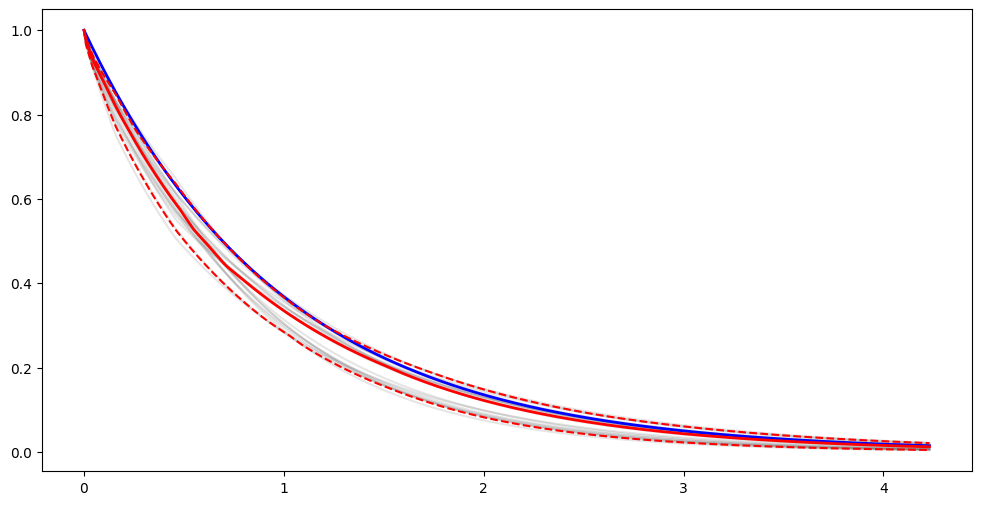

In [14]:
plot_S1("2", 1000, 1, "logarithmic", end_index = 19, ci = True)

In [7]:
# Load the simulated dataset
sim_dataset = load_file("SimulationDataset2/Scenario2/n3000", 1, "haight", train_images, test_images)

_, s_t = initialize_alpha_s(sim_dataset["t_train"], sim_dataset["delta_train"], n_cuts = 5)

# We must be careful with the batch_size! Lowering it may lead to the model converging too early!
result = fit_cure_model("haight", None,
                        sim_dataset["t_train"], sim_dataset["t_val"],
                        sim_dataset["delta_train"], sim_dataset["delta_val"],
                        sim_dataset["img_train"], sim_dataset["img_val"],
                        batch_size = None, max_iterations = 60, early_stopping_em_eps = 1.0e-5,
                        seed = 1, verbose = 3)

I0000 00:00:1741527763.801392   83916 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
E0000 00:00:1741527765.000529   84034 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741527765.006079   84034 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1741527767.343000   84034 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1741527767.384188   84034 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4000 MB memory:  -> devi

******* Warning: The cure probability for this model lies between 0.500000 and 1.000000 *******
Iniciando passo 1


I0000 00:00:1741527769.685078   84099 cuda_dnn.cc:529] Loaded cuDNN version 90300
 13%|█▎        | 13/100 [00:04<00:30,  2.87epoch/s, loss=0.563, loss_val=0.542]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 8.289699898709182e-06
Distância Parâmetros Alpha: 1.8548897227035328
Média das distâncias: 0.9274490062017158
Iniciando passo 2


 21%|██        | 21/100 [00:03<00:13,  5.83epoch/s, loss=0.619, loss_val=0.593]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.8115396740510107e-06
Distância Parâmetros Alpha: 0.08232907550311447
Média das distâncias: 0.04116594352139426
Iniciando passo 3


 11%|█         | 11/100 [00:02<00:17,  5.16epoch/s, loss=0.716, loss_val=0.685]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.8001282786046357e-07
Distância Parâmetros Alpha: 0.06922955887444557
Média das distâncias: 0.03461491944363671
Iniciando passo 4


  6%|▌         | 6/100 [00:01<00:21,  4.43epoch/s, loss=0.969, loss_val=0.897]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.655683565350341e-08
Distância Parâmetros Alpha: 0.09671398817955819
Média das distâncias: 0.048357022368196924
Iniciando passo 5


 73%|███████▎  | 73/100 [00:11<00:04,  6.37epoch/s, loss=0.644, loss_val=0.627]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.81456541382522e-05
Distância Parâmetros Alpha: 0.1478535634519755
Média das distâncias: 0.07393585455305687
Iniciando passo 6


  6%|▌         | 6/100 [00:01<00:22,  4.25epoch/s, loss=0.822, loss_val=0.756]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.296388379116941e-08
Distância Parâmetros Alpha: 0.06771312339876355
Média das distâncias: 0.03385659318132367
Iniciando passo 7


 19%|█▉        | 19/100 [00:03<00:14,  5.62epoch/s, loss=1.53, loss_val=1.34]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.06648325084283e-07
Distância Parâmetros Alpha: 0.2272797562915064
Média das distâncias: 0.11364018146991574
Iniciando passo 8


  6%|▌         | 6/100 [00:01<00:20,  4.52epoch/s, loss=1.41, loss_val=1.25]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 6.495606960031836e-08
Distância Parâmetros Alpha: 0.006174769323921228
Média das distâncias: 0.003087417139995414
Iniciando passo 9


 19%|█▉        | 19/100 [00:03<00:14,  5.75epoch/s, loss=0.829, loss_val=0.765]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 4.210965533047465e-07
Distância Parâmetros Alpha: 0.15603674688554253
Média das distâncias: 0.07801858399104791
Iniciando passo 10


 16%|█▌        | 16/100 [00:03<00:16,  5.22epoch/s, loss=0.876, loss_val=0.812]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.6417689955587903e-07
Distância Parâmetros Alpha: 0.001827603368791885
Média das distâncias: 0.0009139837728457204
Learning rate reduzida para 0.0001
Iniciando passo 11


  8%|▊         | 8/100 [00:01<00:19,  4.75epoch/s, loss=0.895, loss_val=0.818]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 3.963331326682185e-09
Distância Parâmetros Alpha: 0.00030712299107578915
Média das distâncias: 0.00015356347720355793
Iniciando passo 12


  7%|▋         | 7/100 [00:01<00:20,  4.49epoch/s, loss=0.984, loss_val=0.896]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 2.0149541978275835e-09
Distância Parâmetros Alpha: 0.008101156641925816
Média das distâncias: 0.004050579328440007
Iniciando passo 13


  7%|▋         | 7/100 [00:01<00:20,  4.55epoch/s, loss=1.03, loss_val=0.923]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 1.7195524695460892e-09
Distância Parâmetros Alpha: 0.0020333837003613576
Média das distâncias: 0.0010166927099569136
Iniciando passo 14


  6%|▌         | 6/100 [00:01<00:20,  4.50epoch/s, loss=1.07, loss_val=0.95] 


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.660743104316691e-10
Distância Parâmetros Alpha: 0.0013598986177990775
Média das distâncias: 0.000679949591936694
Iniciando passo 15


  6%|▌         | 6/100 [00:01<00:21,  4.44epoch/s, loss=1.11, loss_val=0.975]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.836238448396083e-10
Distância Parâmetros Alpha: 0.0008464213241379893
Média das distâncias: 0.0004232109538809171
Iniciando passo 16


  6%|▌         | 6/100 [00:01<00:21,  4.41epoch/s, loss=1.12, loss_val=0.974]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.821425860185819e-10
Distância Parâmetros Alpha: 7.16668026786163e-05
Média das distâncias: 3.583369241060116e-05
Iniciando passo 17


  6%|▌         | 6/100 [00:01<00:22,  4.27epoch/s, loss=1.16, loss_val=1.01]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.889613999633685e-10
Distância Parâmetros Alpha: 0.000760969776966508
Média das distâncias: 0.00038048518296395395
Iniciando passo 18


  6%|▌         | 6/100 [00:01<00:21,  4.38epoch/s, loss=1.16, loss_val=0.995]


Iniciando treinamento:
Tamanho da amostra de treino: 3000
Tamanho da amostra de validação: 643
Distância Parâmetros Rede Neural: 5.865188993663666e-10
Distância Parâmetros Alpha: 6.459861204448223e-06
Média das distâncias: 3.2302238616737944e-06
Algoritmo convergiu após 18 iterações. Retornando.
Número de arquivos no diretório: 18
